##Prediccion de ventas por sector con prophet

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

#from sklearn.linear_model import *

In [12]:
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

#Traer data

In [13]:
df = pd.read_excel('D:\\Proyectos\\hackaton_talentotech_keydata\\dataexcel\\VentasAnualesTotal.xlsx') 
print(df.head())

                               Subsector  CIIU Rev. 4  \
0  Elaboración de productos alimenticios         1011   
1  Elaboración de productos alimenticios         1012   
2  Elaboración de productos alimenticios         1020   
3  Elaboración de productos alimenticios         1030   
4  Elaboración de productos alimenticios         1031   

                             Descripción CIIU Rev. 4        2008        2009  \
0  Procesamiento y conservación de carne y produc...  4885431058  5284416504   
1  Procesamiento y conservación de pescados, crus...   647038660   524791764   
2  Procesamiento y conservación de frutas, legumb...   319829451   382915646   
3  Elaboración de aceites y grasas de origen vege...  3690226044  3420330726   
4     Extracción de aceites de origen vegetal crudos           0           0   

         2010        2011        2012        2013        2014        2015  \
0  5541725153  6199620913  6431669370  6699900578  7490144402  8319559220   
1   501378066   511413

In [14]:
def prepare_prophet_data(row):
    data = []
    for year in range(2008, 2023):
        if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
            data.append({
                'ds': pd.to_datetime(f'{year}-01-01'),
                'y': float(row[str(year)])
            })
    prophet_df = pd.DataFrame(data)
    return prophet_df


def run_prophet_forecast(df, periods=5):
    model = Prophet(
        yearly_seasonality=True,
        growth='linear',
        interval_width=0.95
    )
    model.fit(df)
    
    future = model.make_future_dataframe(periods=periods, freq='YE')
    forecast = model.predict(future)
    
    return model, forecast

def analyze_row(row, title):
    prophet_df = prepare_prophet_data(row)
    
    model, forecast = run_prophet_forecast(prophet_df)
    
    print(f"\nPrediccion para {title}:")
    future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
    print(future_forecast)
    
    plt.figure(figsize=(12, 6))
    fig = model.plot(forecast)
    plt.title(title)
    plt.show()
    
    # Plot components
    plt.figure(figsize=(12, 8))
    fig = model.plot_components(forecast)
    plt.show()
    
    return forecast

    

04:52:16 - cmdstanpy - INFO - Chain [1] start processing
04:52:16 - cmdstanpy - INFO - Chain [1] done processing



Forecast for Elaboración de productos alimenticios - Procesamiento y conservación de carne y productos :
           ds          yhat    yhat_lower    yhat_upper
15 2022-12-31  1.483127e+10  1.224504e+10  1.743399e+10
16 2023-12-31  1.532103e+10  1.271117e+10  1.805892e+10
17 2024-12-31  1.707994e+10  1.458587e+10  1.989447e+10
18 2025-12-31  1.763965e+10  1.516469e+10  2.019308e+10
19 2026-12-31  1.816415e+10  1.554613e+10  2.083302e+10


<Figure size 1200x600 with 0 Axes>

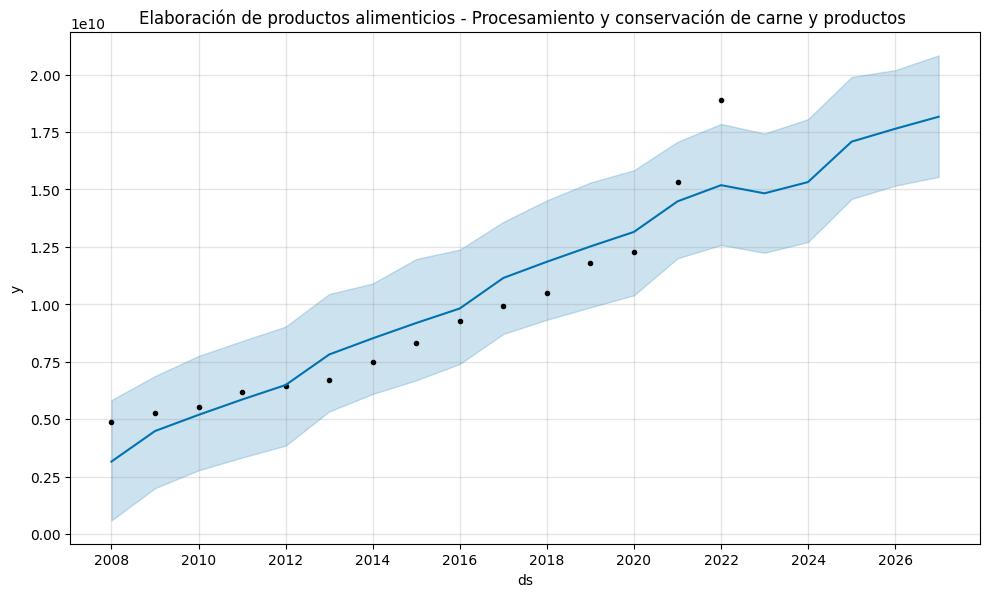

<Figure size 1200x800 with 0 Axes>

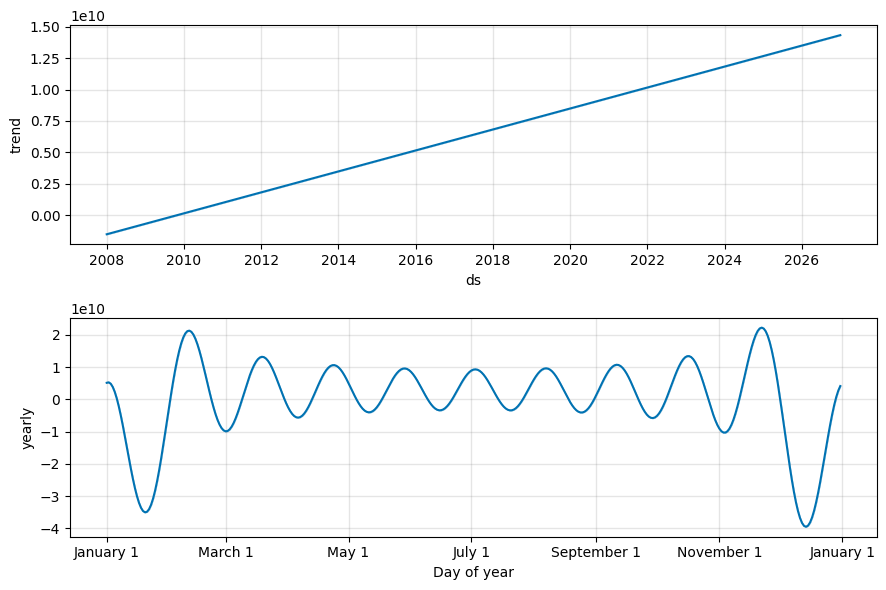


Growth Analysis:
Average yearly growth rate: 11.04%
Total growth over period: 381.05%


In [15]:
# Analyze first row (index 0)
row_data = df.iloc[0]
title = f"{row_data['Subsector']} - {row_data['Descripción CIIU Rev. 4'][:50]}"
forecast = analyze_row(row_data, title)

# Print some additional metrics
actual_values = prepare_prophet_data(row_data)['y'].values
predicted_values = forecast['yhat'][:len(actual_values)].values

print("\nAnalisis de crecimiento:")
print(f"crecimiento promedio por año: {((predicted_values[-1]/predicted_values[0])**(1/len(predicted_values))-1)*100:.2f}%")
print(f"Total crecimiento acumulado: {((predicted_values[-1]/predicted_values[0])-1)*100:.2f}%")

##añadir RNN al juego

04:52:19 - cmdstanpy - INFO - Chain [1] start processing
04:52:19 - cmdstanpy - INFO - Chain [1] done processing
d:\Proyectos\hackaton_talentotech_keydata\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


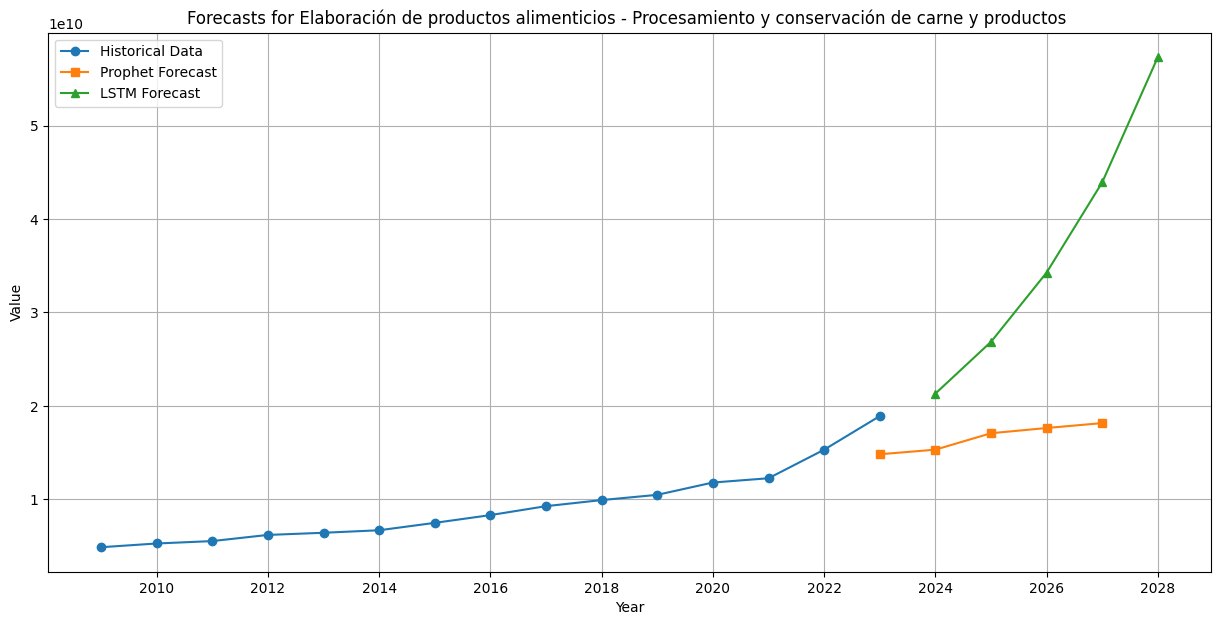

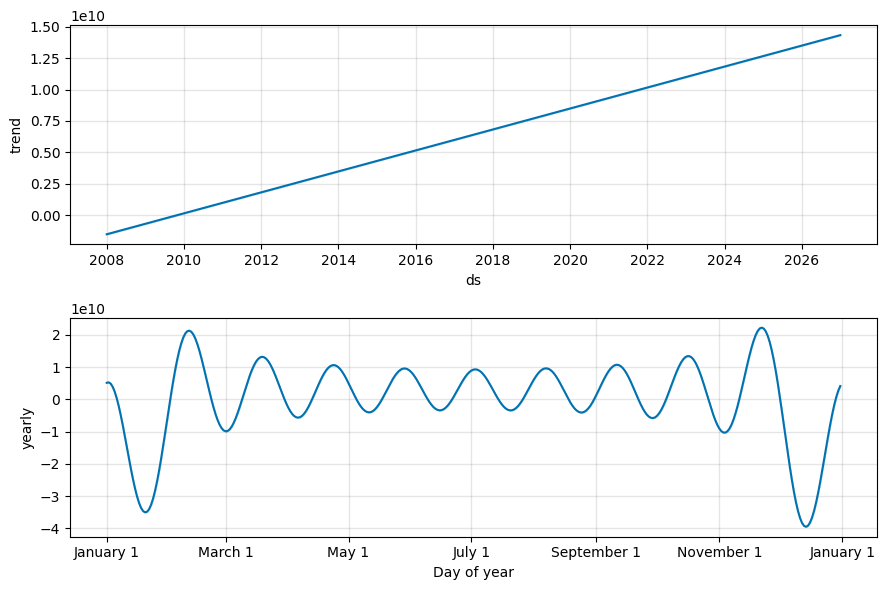


Model Performance Metrics:
Prophet RMSE: 2,664,156,706.75
Prophet MAPE: 22.53%
LSTM RMSE: 783,496,658.28
LSTM MAPE: 5.17%

Forecasts for next 5 years:

Prophet Forecast:
           ds          yhat    yhat_lower    yhat_upper
15 2022-12-31  1.483127e+10  1.323470e+10  1.653548e+10
16 2023-12-31  1.532103e+10  1.357460e+10  1.704583e+10
17 2024-12-31  1.707994e+10  1.554139e+10  1.878474e+10
18 2025-12-31  1.763965e+10  1.587188e+10  1.924648e+10
19 2026-12-31  1.816415e+10  1.640197e+10  1.986119e+10

LSTM Forecast:
        Date      Forecast
0 2023-12-31  2.131281e+10
1 2024-12-31  2.686115e+10
2 2025-12-31  3.427003e+10
3 2026-12-31  4.391953e+10
4 2027-12-31  5.730523e+10


In [16]:

class CombinedForecaster:
    def __init__(self, look_back=3):
        self.look_back = look_back
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.prophet_model = None
        self.lstm_model = None
        
    def create_lstm_dataset(self, dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            dataX.append(dataset[i:(i + look_back)])
            dataY.append(dataset[i + look_back])
        return np.array(dataX), np.array(dataY)
    
    def prepare_prophet_data(self, row):
        data = []
        for year in range(2008, 2023):
            if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
                data.append({
                    'ds': pd.to_datetime(f'{year}-01-01'),
                    'y': float(row[str(year)])
                })
        return pd.DataFrame(data)
    
    def prepare_lstm_data(self, row):
        values = []
        for year in range(2008, 2023):
            if str(year) in row and pd.notna(row[str(year)]) and row[str(year)] != 0:
                values.append(float(row[str(year)]))
        return np.array(values)
    
    def fit_predict(self, row, forecast_periods=5):
        try:
            # Prophet
            prophet_df = self.prepare_prophet_data(row)
            
            # Fit Prophet model
            self.prophet_model = Prophet(yearly_seasonality=True, growth='linear')
            self.prophet_model.fit(prophet_df)
            
            # Make Prophet forecast
            future_dates = self.prophet_model.make_future_dataframe(periods=forecast_periods, freq='YE')
            prophet_forecast = self.prophet_model.predict(future_dates)
            
            # LSTM
            values = self.prepare_lstm_data(row)
            scaled_values = self.scaler.fit_transform(values.reshape(-1, 1))
            
            # Prepare LSTM data
            X, y = self.create_lstm_dataset(scaled_values, self.look_back)
            X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
            
            # Create and fit LSTM model
            self.lstm_model = Sequential([
                LSTM(50, input_shape=(1, self.look_back)),
                Dropout(0.2),
                Dense(1)
            ])
            self.lstm_model.compile(optimizer='adam', loss='mse')
            self.lstm_model.fit(X, y, epochs=100, batch_size=1, verbose=0)
            
            # Make LSTM predictions
            lstm_predictions = []
            current_batch = scaled_values[-self.look_back:]
            
            for i in range(forecast_periods):
                current_batch_reshaped = current_batch.reshape((1, 1, self.look_back))
                next_pred = self.lstm_model.predict(current_batch_reshaped, verbose=0)
                lstm_predictions.append(next_pred[0, 0])
                current_batch = np.roll(current_batch, -1)
                current_batch[-1] = next_pred
                
            # Inverse transform predictions
            lstm_predictions = self.scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))
            
            return prophet_forecast, lstm_predictions
        
        except Exception as e:
            print(f"Error in fit_predict: {str(e)}")
            return None, None
    
    def plot_results(self, row, prophet_forecast, lstm_predictions, title):
        try:
            plt.figure(figsize=(15, 7))
            
            # Plot historical data
            historical_values = self.prepare_lstm_data(row)
            historical_dates = pd.date_range(start='2008-01-01', periods=len(historical_values), freq='YE')
            plt.plot(historical_dates, historical_values, label='Historical Data', marker='o')
            
            # Plot Prophet forecast
            prophet_dates = prophet_forecast['ds'].values[-5:]
            prophet_values = prophet_forecast['yhat'].values[-5:]
            plt.plot(prophet_dates, prophet_values, label='Prophet Forecast', marker='s')
            
            # Plot LSTM forecast
            lstm_dates = pd.date_range(start=historical_dates[-1], periods=6, freq='YE')[1:]
            plt.plot(lstm_dates, lstm_predictions, label='LSTM Forecast', marker='^')
            
            plt.title(f'Forecasts for {title}')
            plt.xlabel('Year')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Plot Prophet components
            self.prophet_model.plot_components(prophet_forecast)
            plt.show()
            
        except Exception as e:
            print(f"Error in plot_results: {str(e)}")
    
    def calculate_metrics(self, actual_values, prophet_forecast, lstm_predictions):
        try:
            # Prepare actual values for comparison
            actual_values = actual_values[self.look_back:]
            
            # Calculate Prophet metrics
            prophet_predictions = prophet_forecast['yhat'][:len(actual_values)]
            prophet_rmse = math.sqrt(mean_squared_error(actual_values, prophet_predictions))
            prophet_mape = mean_absolute_percentage_error(actual_values, prophet_predictions) * 100
            
            # Calculate LSTM metrics
            scaled_actual = self.scaler.transform(actual_values.reshape(-1, 1))
            X_train, y_train = self.create_lstm_dataset(scaled_actual, self.look_back)
            X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            
            lstm_pred_train = self.lstm_model.predict(X_train, verbose=0)
            lstm_pred_train = self.scaler.inverse_transform(lstm_pred_train)
            
            # Align the arrays for comparison
            y_train_actual = actual_values[self.look_back:len(lstm_pred_train) + self.look_back]
            
            lstm_rmse = math.sqrt(mean_squared_error(y_train_actual, lstm_pred_train))
            lstm_mape = mean_absolute_percentage_error(y_train_actual, lstm_pred_train) * 100
            
            return {
                'prophet_rmse': prophet_rmse,
                'prophet_mape': prophet_mape,
                'lstm_rmse': lstm_rmse,
                'lstm_mape': lstm_mape
            }
            
        except Exception as e:
            print(f"Error in calculate_metrics: {str(e)}")
            return None

def analyze_row(df, row_index):
    try:
        row = df.iloc[row_index]
        title = f"{row['Subsector']} - {row['Descripción CIIU Rev. 4'][:50]}"
        
        forecaster = CombinedForecaster(look_back=3)
        prophet_forecast, lstm_predictions = forecaster.fit_predict(row)
        
        if prophet_forecast is not None and lstm_predictions is not None:
            # Plot results
            forecaster.plot_results(row, prophet_forecast, lstm_predictions, title)
            
            # Calculate and print metrics
            actual_values = forecaster.prepare_lstm_data(row)
            metrics = forecaster.calculate_metrics(actual_values, prophet_forecast, lstm_predictions)
            
            if metrics:
                print("\nMetricas de rendimiento:")
                print(f"Prophet RMSE: {metrics['prophet_rmse']:,.2f}")
                print(f"Prophet MAPE: {metrics['prophet_mape']:.2f}%")
                print(f"LSTM RMSE: {metrics['lstm_rmse']:,.2f}")
                print(f"LSTM MAPE: {metrics['lstm_mape']:.2f}%")
            
            print("\nPrediccion siguientes 5 años:")
            print("\nPrediccion Prophet:")
            print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
            print("\nPrediccion LSTM:")
            future_dates = pd.date_range(start='2023-01-01', periods=5, freq='YE')
            lstm_df = pd.DataFrame({
                'Fecha': future_dates,
                'Prediccion': lstm_predictions.flatten()
            })
            print(lstm_df)
            
            return prophet_forecast, lstm_predictions
        else:
            print("Error: Modelos fallidos")
            return None, None
            
    except Exception as e:
        print(f"Error analizando columna: {str(e)}")
        return None, None

# Analyze the first row
prophet_forecast, lstm_predictions = analyze_row(df, 0)

#Creando a Lukita

In [27]:
def cargar_api_key(archivo='D:\\Proyectos\\hackaton_talentotech_keydata\\keys\\googleKey.txt'):
    with open(archivo, 'r') as f:
        lineas = f.readlines()
        for linea in lineas:
            if linea.startswith('API_KEY'):
                return linea.split('=')[1].strip()  # Devuelve la clave sin espacios

api_key = cargar_api_key()


In [18]:
GOOGLE_API_KEY=api_key

import google.generativeai as genai
genai.configure(api_key=GOOGLE_API_KEY)
model=genai.GenerativeModel('gemini-1.5-flash')
response = model.generate_content("Hola, te compartire informacion de un modelo prophet y un LSTM, podrias decirme que opinas,Model Performance Metrics:Prophet RMSE: 2,664,156,706.75Prophet MAPE: 22.53%LSTM RMSE: 783,496,658.28LSTM MAPE: 5.17%")
print(response.text)

## Análisis de los resultados del modelo Prophet y LSTM:

En base a los indicadores de rendimiento proporcionados, el **modelo LSTM parece ser significativamente mejor que el modelo Prophet** para predecir los datos. 

**Aquí hay algunas observaciones:**

* **RMSE:** El RMSE del modelo LSTM es mucho más bajo que el del modelo Prophet. Esto significa que las predicciones del modelo LSTM están más cerca de los valores reales, lo que indica una mayor precisión.
* **MAPE:**  El MAPE del modelo LSTM también es significativamente menor que el del modelo Prophet. Esto indica que el modelo LSTM tiene un error de porcentaje medio absoluto más bajo, lo que sugiere una mayor precisión en las predicciones.

**Consideraciones adicionales:**

* **Naturaleza de los datos:**  Es importante considerar la naturaleza de los datos que se están utilizando para entrenar los modelos.  El modelo Prophet se desempeña bien con series de tiempo que presentan patrones estacionales y tendencias lineales. Si los da